In [44]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# from custom_model import LSTM_fixed_len
from custom_model import AttentionModel

from custom_dataset import customDataset
from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.utils import resample,shuffle
from torchviz import make_dot, make_dot_from_trace

from utils import load_checkpoint

In [45]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [46]:
data_path = '../data'
model_path = '../model'

In [47]:
df_ = pd.read_csv(os.path.join(data_path,'label.csv'))

In [48]:
df_

,Label,message_user
0,0,Bạn ưiii
1,0,Cho mk xin sdt thầy đức đc ko ạ
2,2,Email cx đc hic
3,0,hello
4,5,Cho e hỏi
...,...,...
4179,0,nên e cũng đang xem mk hợp vs cái j
4180,0,vâng. mong là như z
4181,6,vâng. e cảm ơn ạ
4182,1,mrhd tổ chức sự kiện rất mong được xin hình ản...


In [49]:
question = df_[df_['Label']!=0]
question['Label'] = [item-1 for item in list(question['Label'])]
question

/tmp/ipykernel_30708/2757092553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question['Label'] = [item-1 for item in list(question['Label'])]


,Label,message_user
2,1,Email cx đc hic
4,4,Cho e hỏi
5,2,Chưa đc txuc nhiều với mt có học dc htttql k ạ
7,4,ad cho em hỏi chút về ngành của mình với ạ
8,4,Em muốn hỏi ngành của mình học thì có những mô...
...,...,...
4173,0,vâng.hjhj
4174,5,ths ạ.
4181,5,vâng. e cảm ơn ạ
4182,0,mrhd tổ chức sự kiện rất mong được xin hình ản...


In [50]:
# def upsample(df,target_num):
class_0 = question[question['Label']==0]
class_0_upsampled = resample(class_0,random_state=42,n_samples=250-len(class_0),replace=True)
question_upsampled = pd.concat([question, class_0_upsampled])

In [51]:
len(class_0)

242

In [52]:
question_upsampled['Label'].value_counts()

4    1234
5     430
2     259
0     250
1     121
3      64
6       1
Name: Label, dtype: int64

In [53]:
question  = question_upsampled

In [54]:
question['length'] = [len(item) for item in list(question['message_user'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['message_user'])]

In [55]:
np.mean(question['num_word'])

13.307757524374734

(array([1.587e+03, 5.830e+02, 1.330e+02, 2.500e+01, 1.800e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  1. ,  14.6,  28.2,  41.8,  55.4,  69. ,  82.6,  96.2, 109.8,
        123.4, 137. ]),
 <BarContainer object of 10 artists>)

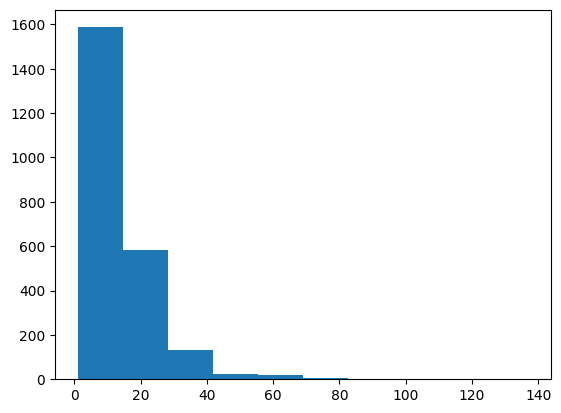

In [56]:
plt.hist(list(question['num_word']), bins = 10)

In [57]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [58]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['message_user']))

In [59]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 2707
num_words after: 1308


In [60]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [61]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [62]:
N = 15
question['encoded'] = question['message_user'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

,Label,message_user,length,num_word,encoded
2,1,Email cx đc hic,15,4,"[[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]"
4,4,Cho e hỏi,9,3,"[[5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]"
5,2,Chưa đc txuc nhiều với mt có học dc htttql k ạ,46,12,"[[1, 3, 1, 8, 9, 10, 11, 12, 13, 14, 15, 0, 0,..."
7,4,ad cho em hỏi chút về ngành của mình với ạ,42,11,"[[16, 17, 18, 7, 19, 20, 21, 22, 23, 9, 15, 0,..."
8,4,Em muốn hỏi ngành của mình học thì có những mô...,84,21,"[[24, 25, 7, 21, 22, 23, 26, 27, 28, 29, 30, 3..."


In [63]:
X = list(question['encoded'])
y = list(question['Label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)

In [64]:
len(X_train),len(X_valid)

(1887, 472)

In [65]:
from sklearn.utils.class_weight import compute_class_weight


In [66]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

tensor([  1.3345,   2.5673,   1.3684,   5.2857,   0.2731,   0.7836, 269.5714])

In [67]:
train_ds = customDataset(X_train, y_train)
valid_ds = customDataset(X_valid, y_valid)

In [68]:
batch_size = 30
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, drop_last= True, shuffle = True)
val_dl = DataLoader(valid_ds, batch_size=batch_size , drop_last= True, shuffle = True)

In [69]:
model = AttentionModel(
                    batch_size=batch_size, 
                    output_size=class_weights.shape[0], 
                    hidden_size=128, 
                    vocab_size=vocab_size, 
                    embedding_length=400
                    )

In [70]:
model = model.train()
model.cpu()

AttentionModel(
  (word_embeddings): Embedding(1310, 400)
  (lstm): LSTM(400, 128)
  (label): Linear(in_features=128, out_features=7, bias=True)
)

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [72]:
# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
min_loss = float('inf')

def save_checkpoint(state, filename= 'checkpoint.pth.tar'):
    print('Saving checkpoint')
    torch.save(state, filename)

num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    losses = []

    print(f'Epoch: {epoch}')

    for batch_idx, (data, labels) in tqdm(enumerate(train_dl), desc=f'Epoch {epoch}'):
        data = data.long()
        labels = labels.type(torch.int64)

        # forward
        preds = model(data)
        loss = criterion(preds, labels)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    print(f'Loss at epoch %d was %.5f' % (epoch, losses[-1]))

    checkpoint = {'model': model , 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    save_checkpoint(checkpoint, filename = os.path.join(model_path,'last.pth'))

    if losses[-1] < min_loss:
      min_loss = losses[-1]
      checkpoint = {'model': model ,'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
      save_checkpoint(checkpoint, filename= os.path.join(model_path,'best.pth'))

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.long()
            y = y.type(torch.int64)

            preds = model(x)
            _, predictions = preds.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f} %')

    model.train()


print('Train accuracy:')
check_accuracy(train_dl, model)
print('Test accuaracy:')
check_accuracy(val_dl, model)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0


Epoch 0: 62it [00:02, 29.59it/s]
  5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

Loss at epoch 0 was 1.52357
Saving checkpoint
Saving checkpoint
Epoch: 1


Epoch 1: 62it [00:02, 26.75it/s]
 10%|█         | 2/20 [00:04<00:41,  2.30s/it]

Loss at epoch 1 was 0.74815
Saving checkpoint
Saving checkpoint
Epoch: 2


Epoch 2: 62it [00:02, 27.13it/s]
 15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]

Loss at epoch 2 was 0.51331
Saving checkpoint
Saving checkpoint
Epoch: 3


Epoch 3: 62it [00:02, 27.93it/s]
 20%|██        | 4/20 [00:09<00:37,  2.31s/it]

Loss at epoch 3 was 0.26689
Saving checkpoint
Saving checkpoint
Epoch: 4


Epoch 4: 62it [00:02, 24.13it/s]
 25%|██▌       | 5/20 [00:11<00:36,  2.44s/it]

Loss at epoch 4 was 0.22425
Saving checkpoint
Saving checkpoint
Epoch: 5


Epoch 5: 62it [00:02, 24.92it/s]
 30%|███       | 6/20 [00:14<00:34,  2.49s/it]

Loss at epoch 5 was 0.06144
Saving checkpoint
Saving checkpoint
Epoch: 6


Epoch 6: 62it [00:02, 24.43it/s]
 35%|███▌      | 7/20 [00:17<00:32,  2.53s/it]

Loss at epoch 6 was 0.02017
Saving checkpoint
Saving checkpoint
Epoch: 7


Epoch 7: 62it [00:02, 25.82it/s]
 40%|████      | 8/20 [00:19<00:30,  2.51s/it]

Loss at epoch 7 was 0.06983
Saving checkpoint
Epoch: 8


Epoch 8: 62it [00:02, 24.55it/s]
 45%|████▌     | 9/20 [00:22<00:27,  2.53s/it]

Loss at epoch 8 was 0.03170
Saving checkpoint
Epoch: 9


Epoch 9: 62it [00:02, 23.66it/s]
 50%|█████     | 10/20 [00:24<00:25,  2.57s/it]

Loss at epoch 9 was 0.08079
Saving checkpoint
Epoch: 10


Epoch 10: 62it [00:02, 22.57it/s]
 55%|█████▌    | 11/20 [00:27<00:23,  2.64s/it]

Loss at epoch 10 was 0.02492
Saving checkpoint
Epoch: 11


Epoch 11: 62it [00:02, 22.63it/s]
 60%|██████    | 12/20 [00:30<00:21,  2.71s/it]

Loss at epoch 11 was 0.00518
Saving checkpoint
Saving checkpoint
Epoch: 12


Epoch 12: 62it [00:02, 21.50it/s]
 65%|██████▌   | 13/20 [00:33<00:19,  2.78s/it]

Loss at epoch 12 was 0.00951
Saving checkpoint
Epoch: 13


Epoch 13: 62it [00:03, 20.53it/s]
 70%|███████   | 14/20 [00:36<00:17,  2.87s/it]

Loss at epoch 13 was 0.00845
Saving checkpoint
Epoch: 14


Epoch 14: 62it [00:02, 22.56it/s]
 75%|███████▌  | 15/20 [00:39<00:14,  2.85s/it]

Loss at epoch 14 was 0.00576
Saving checkpoint
Epoch: 15


Epoch 15: 62it [00:02, 25.05it/s]
 80%|████████  | 16/20 [00:41<00:11,  2.76s/it]

Loss at epoch 15 was 0.01400
Saving checkpoint
Epoch: 16


Epoch 16: 62it [00:02, 22.97it/s]
 85%|████████▌ | 17/20 [00:44<00:08,  2.76s/it]

Loss at epoch 16 was 0.00682
Saving checkpoint
Epoch: 17


Epoch 17: 62it [00:03, 20.24it/s]
 90%|█████████ | 18/20 [00:47<00:05,  2.88s/it]

Loss at epoch 17 was 0.00381
Saving checkpoint
Saving checkpoint
Epoch: 18


Epoch 18: 62it [00:02, 23.09it/s]
 95%|█████████▌| 19/20 [00:50<00:02,  2.84s/it]

Loss at epoch 18 was 0.02561
Saving checkpoint
Epoch: 19


Epoch 19: 62it [00:02, 22.29it/s]
100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


Loss at epoch 19 was 0.04759
Saving checkpoint
Train accuracy:


100%|██████████| 62/62 [00:00<00:00, 115.86it/s]


Got 1854 / 1860 with accuracy 99.68 %
Test accuaracy:


100%|██████████| 15/15 [00:00<00:00, 106.44it/s]

Got 360 / 450 with accuracy 80.00 %


In [74]:
from pytorch_model_summary import summary
print(summary(model, torch.zeros([30,22]).long(), show_input=True))

-------------------------------------------------------------------------------------------------
      Layer (type)                                   Input Shape         Param #     Tr. Param #
       Embedding-1                                      [30, 22]         524,000         524,000
            LSTM-2     [22, 30, 400], [1, 30, 128], [1, 30, 128]         271,360         271,360
          Linear-3                                     [30, 128]             903             903
Total params: 796,263
Trainable params: 796,263
Non-trainable params: 0
-------------------------------------------------------------------------------------------------


# Test

In [75]:
# vocab2index

In [76]:
torch.save(vocab2index,os.path.join(model_path,'vocab_12jul.pth'))

In [77]:
vocab2index = torch.load(os.path.join(model_path,'vocab_12jul.pth'))

In [78]:
N

15

In [79]:
pad_enc = torch.zeros([29,15])
# pad_enc.shape

In [80]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,N))
test_enc

tensor([[  16.,   17.,   18.,    7.,   21.,  855., 1104.,   28.,  628.,   44.,
           15.,    0.,    0.,    0.,    0.]])

In [81]:
test_enc_pad = torch.cat([test_enc,pad_enc])
test_enc_pad.shape

torch.Size([30, 15])

In [82]:

preds = model(test_enc_pad.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds[0])
pred_label = prop_preds.argmax().item()
pred_label

tensor([3.8830e-06, 8.3030e-06, 1.4212e-03, 1.9437e-05, 9.9846e-01, 6.0418e-05,
        2.2763e-05], grad_fn=<SelectBackward0>)


4